# Visualização do funcionamento do algoritmo do Kapetanovic

Esse jupyter tem como objetivo verificar o funcionamento do esquema de detecção de contaminação piloto 1B do artigo do Kapetanovic. O esquema é baseado na razão dos dois maiores autovalores da matriz R. Vamos ver como essa razão é alterada em função do número de usuários conectados na rede, qtd de antenas, SNR, e qtd de símbolos na sequência piloto.

### Importações

O arquivo "comm" possui as funções necessárias para simular a modulação QPSK, adicionar ruído branco na transmissão, e, por último, uma função que constroi a matriz R e retorna a razão de seus dois maiores autovalores.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import sys
from IPython.display import display, clear_output

sys.path.append("../Python/")
import comm

In [2]:
#DEFININDO ALGUNS PARÂMETROS DO GRÁFICO
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {
    'figure.figsize': [10, 5],
    'figure.titlesize': 12, 
    'axes.labelsize': 8,
    'axes.titlesize': 10, 
    'font.size': 8,
    'legend.fontsize': 8, 
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6,
    'axes.axisbelow': True
}
plt.rcParams.update(params)

### Definição de Funções

In [3]:
def simularPropagacaoSinal(qtdSimbolosPiloto, bitsPorSimbolo, qtdAntenas, qtdUsuarios, potenciaEspiao, snr, qtdEspioes=1):
    
    # SIMULANDO OS CANAIS DO USUARIO E DO ESPIAO
    Haut = np.sqrt(0.5)*(np.random.normal(0, 1, size=(qtdAntenas, qtdUsuarios)) + 1j*np.random.normal(0, 1, size=(qtdAntenas, qtdUsuarios)))
    g    = np.sqrt(0.5)*(np.random.normal(0, 1, size=(qtdAntenas, qtdEspioes)) + 1j*np.random.normal(0, 1, (qtdAntenas, qtdEspioes)))

    # SEQUENCIA PILOTO ALEATORIA + MODULACAO PARA TODOS OS USUARIOS:
    bitStream = np.random.choice([0, 1], qtdSimbolosPiloto*bitsPorSimbolo*qtdUsuarios)
    symb      = comm.qpskmodulator(bitStream) # QPSK Modulator
    xp        = symb.reshape(qtdUsuarios, qtdSimbolosPiloto)

    # ESPIAO ENTRANDO NA JOGADA (SE A POTENCIA DELE FOR 0 ELE NAO ENTRA NA JOGADA):
    xpe  = np.sqrt(potenciaEspiao)*xp[0, :] # xpe vai ser a sequencia piloto do primeiro usuario multiplicada pela raiz da potencia do espiao
    xptx = np.concatenate((xp, [xpe])) # xptx sera a matriz xp com uma linha a mais: xpe
    H    = np.concatenate((Haut, g), axis=1) # H vai ser Haut com uma COLUNA a mais, que vai ser g

    # TRANSMISSAO PELO CANAL
    Y = np.dot(H, xptx) # fading
    Y = comm.awgn(Y, SNR=snr) # ruido branco
    
    return Y, xp, H[:,0]

In [4]:
def estimarCanal(Y, xp):
    # HEST =(Y * xptranspostoconjugado ) * ((xp*xptranspconj)^(-1))
    # HEST -> cada coluna um usuario. No caso de um único usuário pegar a primeira coluna
    # return Hest(coluna 0)
    
    Hest = np.matmul(np.matmul(Y, np.conjugate(xp).T), np.linalg.inv(np.matmul(xp, np.conjugate(xp).T)))
    return Hest[:,0]

In [5]:
def mse(HestCol0, HCol0):
    pass
    # HestCol0 é o da função de cima mas só a primeira coluna
    # HCol0 é a primeira coluna do hzão 
    # comparar os elementos desses vetores pra fazer o mse
    return np.sum(((HestCol0 - HCol0).real)**2)/len(HestCol0)

In [6]:
def calcularEnergiaHassan(HestCol0, snr, qtdAntenas, qtdSimbolosPiloto):
    
    N0       = 1/(10**(snr/10))
    sovertau = qtdAntenas*N0/qtdSimbolosPiloto
    ln       = np.log((2+sovertau)/(1+sovertau))
    eta      = (1 + sovertau)*(2+sovertau)*ln
    E        = np.matmul(np.conjugate(HestCol0).T, HestCol0)/qtdAntenas
    
    return E, eta

In [7]:
def main(qtdSimbolos, bitsPorSimbolo, qtdAntenas, qtdUsuarios, potenciaEspiao, snr, qtdEspioes):
    
    # PROPAGACAO DO SINAL
    Y, xp, HCol0 = simularPropagacaoSinal(qtdSimbolos, bitsPorSimbolo, qtdAntenas, qtdUsuarios, potenciaEspiao, snr, qtdEspioes)
        
    # ESTIMATIVA DO CANAL
    HestCol0 = estimarCanal(Y, xp)
    
    # CALCULO DA ENERGIA
    E, eta = calcularEnergiaHassan(HestCol0, snr, qtdAntenas, qtdSimbolos)
    
    return E.real, eta

### Verificando o MSE em função da SNR

In [8]:
# PARAMETROS
qtdEspioes        = 1
qtdBitsPorSimbolo = 2
repetibilidade    = 10
potenciaUsuario   = 1
qtdUsuarios       = 1
qtdAntenas        = 200
potenciaEspiao    = 0
qtdSimbolos       = 100
rangeSNRs         = np.arange(-10, 21, 2.5)

# VARIANDO AS SNRS
somaMSEsCadaSNR = []
for snrAtual in rangeSNRs:
    
    # REPETIBILIDADE
    somaMSESNRAtual = 0
    for i in range(repetibilidade):
        
        # PROPAGACAO DO SINAL
        Y, xp, HCol0 = simularPropagacaoSinal(qtdSimbolos, qtdBitsPorSimbolo, qtdAntenas, qtdUsuarios, potenciaEspiao, snrAtual, qtdEspioes)
        
        # ESTIMATIVA DO CANAL
        HestCol0 = estimarCanal(Y, xp)
        
        # MSE
        somaMSESNRAtual += mse(HestCol0, HCol0)
        
    # COLOCO A SOMA DOS MSE DESSA SNR NO ARRAY
    somaMSEsCadaSNR.append(somaMSESNRAtual/repetibilidade)

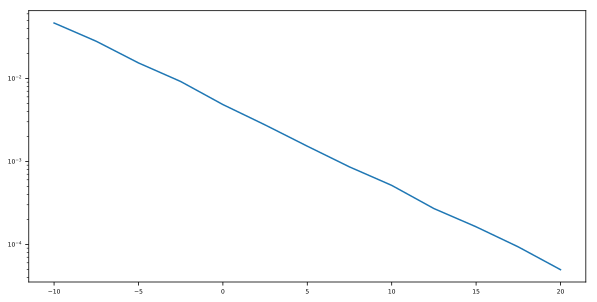

In [9]:
plt.plot(rangeSNRs, somaMSEsCadaSNR)
plt.yscale("log")

### Verificando que E >= eta quando há contaminação

In [12]:
# PARAMETROS
qtdEspioes          = 1
qtdBitsPorSimbolo   = 2
repetibilidade      = 10
potenciaUsuario     = 1
qtdUsuarios         = 1
qtdAntenas          = 200
qtdSimbolos         = 100
rangePotenciaEspiao = np.array([0, 1, 2, 3])
rangeSNRs           = np.arange(0, 51, 2.5)

# VARIANDO A POTENCIA DO ESPIAO
for potenciaEspiaoAtual in rangePotenciaEspiao:

    # VARIANDO AS SNRS
    for snrAtual in rangeSNRs:
        
        print("\nPOTÊNCIA ESPIÃO:", potenciaEspiaoAtual, "SNR:", snrAtual)

        # REPETIBILIDADE
        for i in range(repetibilidade):

            # RODANDO TUDO
            E, eta = main(qtdSimbolos, qtdBitsPorSimbolo, qtdAntenas, qtdUsuarios, potenciaEspiaoAtual, snrAtual, qtdEspioes)

            print(E, eta, E>=eta)


POTÊNCIA ESPIÃO: 0 SNR: 0.0
1.072105514302775 3.4521848694213704 False
1.0685162980909406 3.4521848694213704 False
1.0228051967552096 3.4521848694213704 False
0.8727632044601765 3.4521848694213704 False
0.9661104304267515 3.4521848694213704 False
1.0263686298769066 3.4521848694213704 False
1.0360689482370955 3.4521848694213704 False
1.0020630147513832 3.4521848694213704 False
0.9984564034860358 3.4521848694213704 False
1.0071807302515996 3.4521848694213704 False

POTÊNCIA ESPIÃO: 0 SNR: 2.5
1.0018081201887097 2.5607147136235677 False
0.9501416287292245 2.5607147136235677 False
0.8892629121388285 2.5607147136235677 False
0.9656105158865006 2.5607147136235677 False
0.8815127822799644 2.5607147136235677 False
1.057907917867177 2.5607147136235677 False
1.0210171647295667 2.5607147136235677 False
1.2085788489156302 2.5607147136235677 False
1.0334838738638505 2.5607147136235677 False
0.9518685439613424 2.5607147136235677 False

POTÊNCIA ESPIÃO: 0 SNR: 5.0
0.944810017258732 2.053418116579925

1.033380442394003 1.3863327520213367 False
1.0199032517623374 1.3863327520213367 False
1.0698386556093518 1.3863327520213367 False
1.03053141965488 1.3863327520213367 False
0.8837918319898842 1.3863327520213367 False

POTÊNCIA ESPIÃO: 0 SNR: 50.0
0.9676947002177582 1.3863159499279838 False
1.0343025374110537 1.3863159499279838 False
0.9316258580556391 1.3863159499279838 False
1.133756501339773 1.3863159499279838 False
0.9882243150981999 1.3863159499279838 False
0.9805576020644032 1.3863159499279838 False
1.0865931336022425 1.3863159499279838 False
0.8875505929389808 1.3863159499279838 False
1.0479278539368055 1.3863159499279838 False
0.9809586987947149 1.3863159499279838 False

POTÊNCIA ESPIÃO: 1 SNR: 0.0
1.943844855604104 3.4521848694213704 False
1.9242176734832839 3.4521848694213704 False
1.7997785348923958 3.4521848694213704 False
1.7968753022670259 3.4521848694213704 False
1.8501507175813428 3.4521848694213704 False
2.0320865251918914 3.4521848694213704 False
1.9940700252410595 3.4

2.1190928814744465 1.3863626307699441 True
2.081145333428256 1.3863626307699441 True
1.8775780980719523 1.3863626307699441 True
2.2221367615422447 1.3863626307699441 True
1.8766572632286094 1.3863626307699441 True
2.003892440883987 1.3863626307699441 True
2.0117942010736547 1.3863626307699441 True
2.117841876815029 1.3863626307699441 True

POTÊNCIA ESPIÃO: 1 SNR: 47.5
2.0645403861128653 1.3863327520213367 True
2.0339202037066495 1.3863327520213367 True
2.2795400460280537 1.3863327520213367 True
2.290475387348844 1.3863327520213367 True
1.9682877512133048 1.3863327520213367 True
2.2561924223384806 1.3863327520213367 True
1.8615466823555569 1.3863327520213367 True
2.047471390083981 1.3863327520213367 True
1.9704286649589609 1.3863327520213367 True
2.0137321108998667 1.3863327520213367 True

POTÊNCIA ESPIÃO: 1 SNR: 50.0
1.9163347818587915 1.3863159499279838 True
1.7132543116047152 1.3863159499279838 True
2.0077512809742175 1.3863159499279838 True
1.7879674641827017 1.3863159499279838 True

3.268881515712585 1.3866782636639705 True
3.2023483034664344 1.3866782636639705 True
3.1298352725430063 1.3866782636639705 True

POTÊNCIA ESPIÃO: 2 SNR: 40.0
3.3462515158048145 1.3865102471544473 True
3.0630384980572765 1.3865102471544473 True
2.7533955364375378 1.3865102471544473 True
2.868438183065506 1.3865102471544473 True
3.0011675279979007 1.3865102471544473 True
2.853708607419099 1.3865102471544473 True
3.089911323213804 1.3865102471544473 True
3.17672717733263 1.3865102471544473 True
3.0910553343736873 1.3865102471544473 True
3.54964396106018 1.3865102471544473 True

POTÊNCIA ESPIÃO: 2 SNR: 42.5
2.767732636505173 1.386415763318215 True
3.447526829632303 1.386415763318215 True
2.5121859270367795 1.386415763318215 True
2.8647823005694018 1.386415763318215 True
3.1763078636130433 1.386415763318215 True
3.1086430422189553 1.386415763318215 True
3.1870703116288635 1.386415763318215 True
3.0221896070596213 1.386415763318215 True
2.3658114754953603 1.386415763318215 True
3.04306867831

3.491354399472293 1.3869770371638412 True
4.290354553347028 1.3869770371638412 True
3.8043935259258643 1.3869770371638412 True
4.07970772276333 1.3869770371638412 True

POTÊNCIA ESPIÃO: 3 SNR: 37.5
4.494748629911228 1.3866782636639705 True
3.9967380729408433 1.3866782636639705 True
3.990512001492951 1.3866782636639705 True
3.7430404135200015 1.3866782636639705 True
3.910296802957767 1.3866782636639705 True
4.094954655815569 1.3866782636639705 True
4.08838852806413 1.3866782636639705 True
4.360941254480857 1.3866782636639705 True
4.185496111343973 1.3866782636639705 True
4.394341526904118 1.3866782636639705 True

POTÊNCIA ESPIÃO: 3 SNR: 40.0
3.902339503105486 1.3865102471544473 True
4.136940681051708 1.3865102471544473 True
4.001071999952672 1.3865102471544473 True
4.672803458875629 1.3865102471544473 True
4.222823187736887 1.3865102471544473 True
3.9452314336810783 1.3865102471544473 True
3.957320941686289 1.3865102471544473 True
4.311213530263709 1.3865102471544473 True
3.653264641475